Brain Tumour Segmentation

# Setup

In [1]:
import os
import numpy as np 
import random
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers

# Get the Data

## Get the Data path

In [2]:
import glob

CURRENT_PATH = os.getcwd()
ABS_PATH = os.path.abspath(os.path.join(CURRENT_PATH, os.pardir))

DATASET_PATH = ABS_PATH + "/Dataset"

X_PATHs = glob.glob(DATASET_PATH + "/*/*img.npy")
np.random.shuffle(X_PATHs)
SEG_PATHs = [PATH.replace("img", "seg") for PATH in X_PATHs]

In [3]:
len(X_PATHs)

5391

In [4]:
X_shape = np.load(X_PATHs[0]).shape
X_shape

(240, 240, 3)

In [5]:
y_shape = np.load(SEG_PATHs[0]).shape
y_shape

(240, 240)

In [6]:
img_shape = (240, 240)
n_channels = 3
n_classes = 1

# Visualize the Data

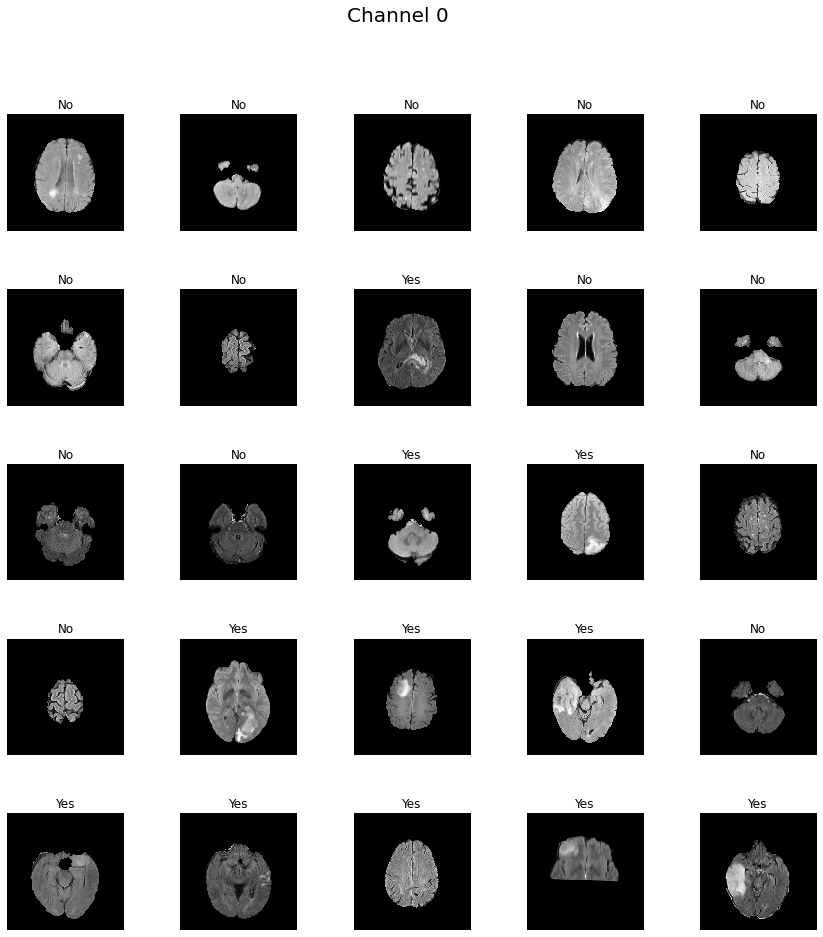

In [6]:
n_rows = 5
n_cols = 5
ch = 0 # channel
plt.figure(figsize=(n_cols * 3, n_rows * 3))
plt.suptitle("Channel %d"%ch, fontsize=20)

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        
        PATH_temp = X_PATHs[index]
        img_temp = np.load(PATH_temp)[:, :, ch]
        plt.imshow(img_temp, cmap="gray", interpolation="nearest")
        plt.axis('off')
        
        title_temp = "Yes" if "Yes" in PATH_temp else "No"
        plt.title(title_temp, fontsize=12)
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [54]:
def plot_images(instances, images_per_row=8, height = 240, width = 240):
    """shape of image is (n, -1)"""
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, height * width))], axis=0)
    
    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, height, width))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * height, images_per_row * width)
    plt.imshow(big_image, cmap="gray")
    plt.axis("off")

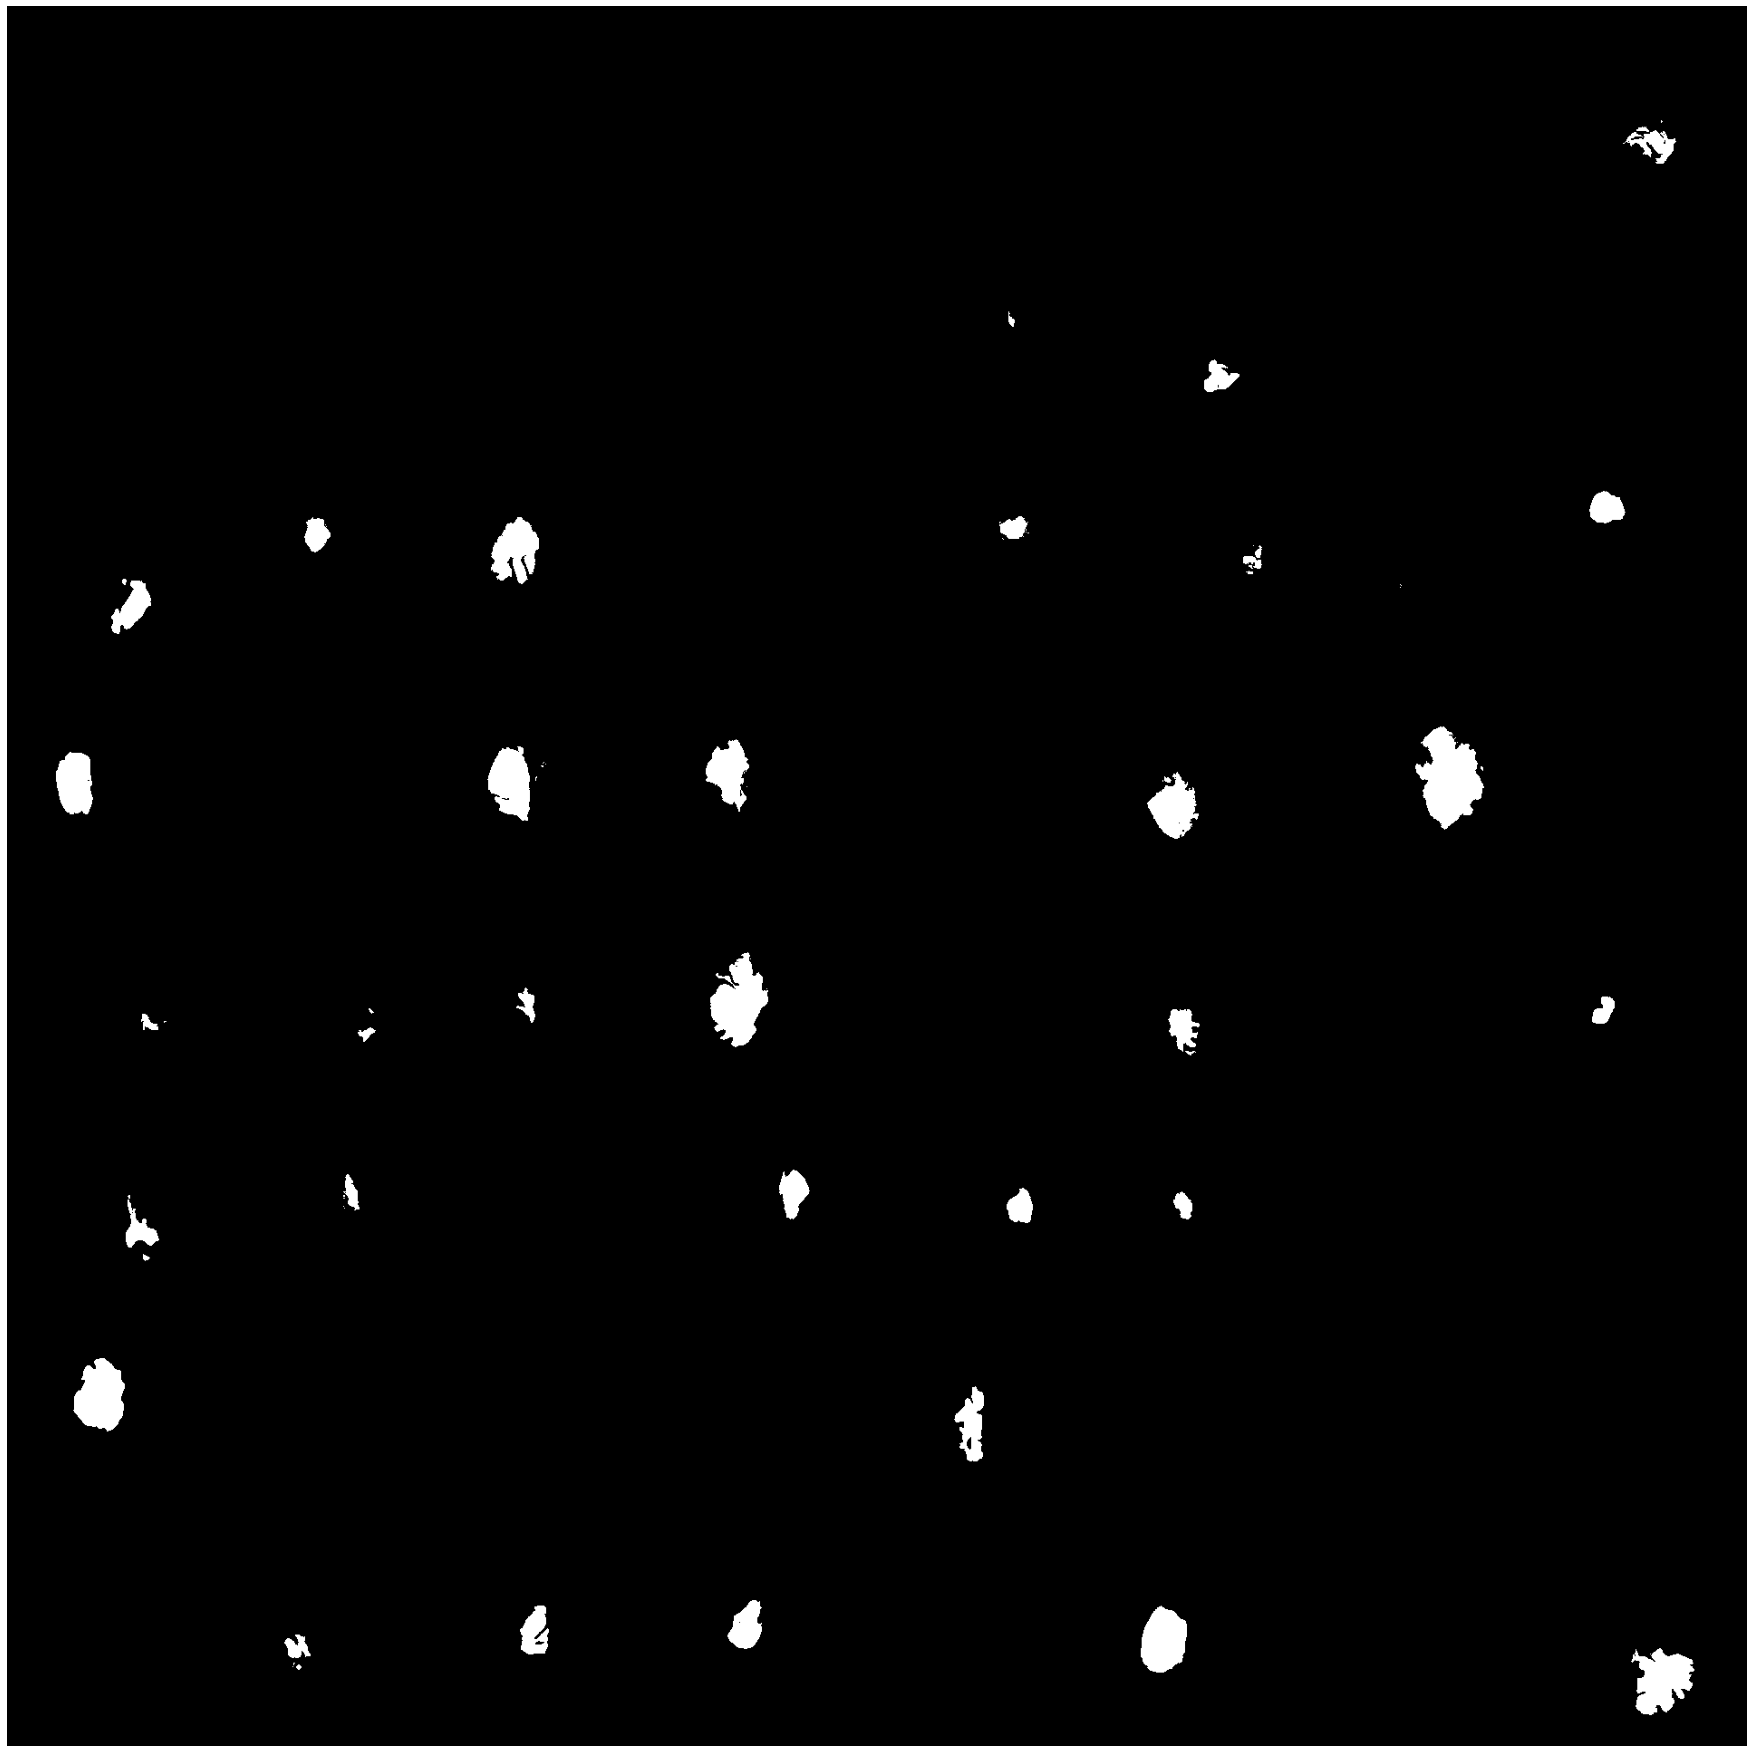

In [8]:
n_plots = 64
seg_plots = np.zeros(((n_plots,) + img_shape))
for (i, PATH) in enumerate(SEG_PATHs[:n_plots]):
    seg_plots[i] = np.load(PATH)

plt.figure(figsize=(32, 32))
plot_images(seg_plots.reshape(n_plots, -1))

# Prepare the Data

## Train and Validation Split

In [7]:
val_split = 0.1
n = len(X_PATHs)
m = round(n*(1 - val_split))

X_train, y_train = X_PATHs[:m], SEG_PATHs[:m]
X_val, y_val = X_PATHs[m:], SEG_PATHs[m:]

## Data Generator

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 list_IDs,
                 img_shape, batch_size,
                 n_channels,
                 shuffle=True):
        'Initialization'
        self.list_IDs = list_IDs
        self.img_shape = img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        batch_size = self.batch_size
        indices = self.indices[index*batch_size : (index+1)*batch_size]

        # Find list of PATHs
        list_IDs_temp = [self.list_IDs[i] for i in indices]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # X : (batch_size, img_shape, n_channels)
        # allocate space
        X = np.empty((self.batch_size, *self.img_shape, self.n_channels))
        y = np.empty((self.batch_size, *self.img_shape, 2), dtype=int)
        y_paths_temp = [ID.replace("img", "seg") for ID in list_IDs_temp]

        # Generate data
        for i, (X_ID, y_ID) in enumerate(zip(list_IDs_temp, y_paths_temp)):
            X[i] = np.load(X_ID)
            y[i] = tf.keras.utils.to_categorical(np.load(y_ID), 2)
            
        return X, y

In [9]:
params = {
    "img_shape": img_shape, 
    "batch_size": 32,
    "n_channels": n_channels, 
}

training_generator = DataGenerator(X_train, **params)
validation_generator = DataGenerator(X_val, **params)

# Build the Model

## Loss Function

In [10]:
def dice_coef(y_true, y_pred, eps=1e-8):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    nume = tf.reduce_sum(abs(y_true * y_pred))
    deno = tf.reduce_sum(y_true**2 + y_pred**2) + eps
    
    return 2*nume/deno

def dice_loss(y_true, y_pred, eps=1e-8):
    return 1 - dice_coef(y_true, y_pred, eps=1e-8)

## Build Model

In [16]:
import Unet

model = Unet.build_model(
    nx=240, ny=240, channels=3,
    num_classes=1,
    layer_depth=3,
)

model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_block_5 (ConvBlock)       (None, 240, 240, 64  38720       ['inputs[0][0]']                 
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 120, 120, 64  0          ['conv_block_5[0][0]']           
                                )                                                              

In [17]:
model.compile(
    loss=dice_loss, 
    optimizer="adam",
    metrics=[dice_coef]
)

## Train the Model

In [ ]:
from time import time

start = time()

epochs = 100
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_dice_coef",
    mode='max',
    patience=5,
)

history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[earlystopping],
)

train_time = time()-start

print("traing time(s):", train_time)

Epoch 1/100
151/151 [==============================] - 4553s 30s/step - loss: 0.2947 - dice_coef: 0.7053 - val_loss: 0.2929 - val_dice_coef: 0.7071
Epoch 2/100
151/151 [==============================] - 4450s 29s/step - loss: 0.2936 - dice_coef: 0.7064 - val_loss: 0.2929 - val_dice_coef: 0.7071
Epoch 3/100
151/151 [==============================] - 4551s 30s/step - loss: 0.2935 - dice_coef: 0.7065 - val_loss: 0.2929 - val_dice_coef: 0.7071
Epoch 4/100
151/151 [==============================] - 4535s 30s/step - loss: 0.2934 - dice_coef: 0.7066 - val_loss: 0.2929 - val_dice_coef: 0.7071
Epoch 5/100
103/151 [===================>..........] - ETA: 27:42 - loss: 0.2933 - dice_coef: 0.7067

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model.save("U_Net.h5")

# Analyse the Result

In [41]:
custom_objects = {
    "dice_coef": dice_coef,
    "dice_loss": dice_loss,
    "ConvBlock": Unet.ConvBlock,
    "UpconvBlock": Unet.UpconvBlock,
    "CropConcatBlock": Unet.CropConcatBlock,
}

model = keras.models.load_model(
    "U_Net.h5", 
    custom_objects=custom_objects,
)

In [50]:
n_samples = 5
X_test = np.zeros(((n_samples,) + img_shape + (n_channels,)))
y_test = np.zeros(((n_samples,) + img_shape))

for i in range(n_samples):
    X_test[i] = np.load(X_PATHs[i])
    y_test[i] = np.load(SEG_PATHs[i])

In [57]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=-1)
dice_coef(y_pred, y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [68]:
y_pred

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [ ]:
y_pred_

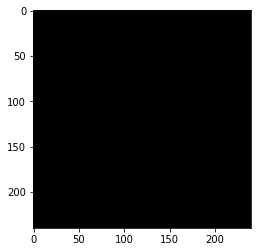

In [67]:
plt.imshow(y_pred_prob[2, :, :, 0], cmap="gray")

In [43]:
y_pred_prob = model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0).reshape(((n_samples,) + img_shape))

dice_coef(y_pred, y_test)

ValueError: cannot reshape array of size 576000 into shape (5,240,240)

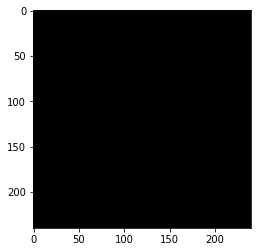

In [52]:
plt.imshow(y_test[0], cmap="gray")

In [ ]:
plt.imshow(y_pred_prob[0], cmap="gray")

In [ ]:
X_test_ch0 = X_test[:, :, :, 0]

plot_images(X_test_ch0.reshape(5, -1), images_per_row=5)

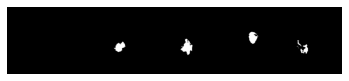

In [55]:
plot_images(y_test.reshape(5, -1), images_per_row=5)

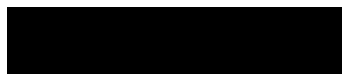

In [56]:
plot_images(np.asarray(y_pred).reshape(5, -1), images_per_row=5)